## Obtaining light curves for RR Lyrae stars in the PAL5 globular cluster

This notebook builds on the previous work of obtaining lightcurves for stars within the Palomar 5 globular cluster by refining the PSF photometry. This will be done by using the master mosaic image for the ePSF model and to build a source list using it due to its lower signal-to-noise ratio (SNR).

The aim is the compare each epoch to the master source list instead of epoch 1 as in the previous notebook and creating a consistent unique ID corresponding to each star across the epochs to make matching the stars easier. Failing this, then converting the sky coordinates into planar x, y coordinates for each epoch and using the master image to find the nearest star.

This will hopefully mean that light curves can be built with slighter higher accuracy by improving the photometry and also reducing the possibility of matching the stars between epochs incorrectly. A brief analysis to ensure there is no systematic error between epochs will be carried out and an attempt to find the standard deviation of stars detected and matched will be done and plotted to identify perhaps stars that vary (will have standard deviations errant compared to the rest of the stellar population).

The next phase in a different notebook is to create a master notebook and begin the process of folding the lightcurves to aid in identifying the periods of the RR Lyrae stars and so calculate their distances.

Contents:

1) list of imports

2) PSF Photometry: -ePSF model using mosaic image; -create master star list -PSF photometry using fixed centroids from the mosaic image on each epoch, saving the data in the filename format: PAL5_PSFphot_02_epochxx_channelxpxum.fits

3) Star matching: -convert both master and epoch coordinates into right ascension and declination values -match the stars between the two lists -copy star ID from master list to epoch list -join the tables together based on the master ID -loop for all epochs

4) Extract magnitudes and errors: -extract the magnitudes and errors for each suspected RRL and some random stars -systematic error analysis from random stars

5) Analysis: -calculate standard deviations and plot -investigate errant stars (could be RRLs)

6) Light curves: -plot and save all the lightcurves

7) Next steps: -prepare to extend lightcurves, fold them and find their periods

In [1]:
import math
import glob
import copy
import numpy as np
import astroalign as aa
import matplotlib
import matplotlib.pyplot as plt
from astropy import wcs
from astropy import units as u
from astropy.io import fits # used for FITS file management
from astropy.io import ascii
from astropy.time import Time
from astropy.stats import sigma_clipped_stats # used within star detection
from astropy.table import Table, join
from astropy.nddata import NDData
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy.coordinates import Angle
from astropy.visualization import simple_norm
from astropy.modeling.fitting import LevMarLSQFitter
from photutils import aperture_photometry # used to perform photometry using annuli
from photutils import DAOStarFinder # used for the star finding algorithm
from photutils import CircularAperture, CircularAnnulus
from photutils import EPSFBuilder
from photutils.psf import extract_stars
from photutils.psf import DAOGroup
from photutils.psf import IterativelySubtractedPSFPhotometry
from photutils.background import MMMBackground
from matplotlib.colors import LogNorm

%matplotlib inline

#### Building ePSF model using master mosaic image

FITS file information:
FILE = PAL5_data/PAL5/PAL5_3p6um.fits
DATE = 2013-05-11T09:41:44.585
FLUXCONV = 0.1257
EXPTIME = 585.054




Number of ePSF sources found = 119



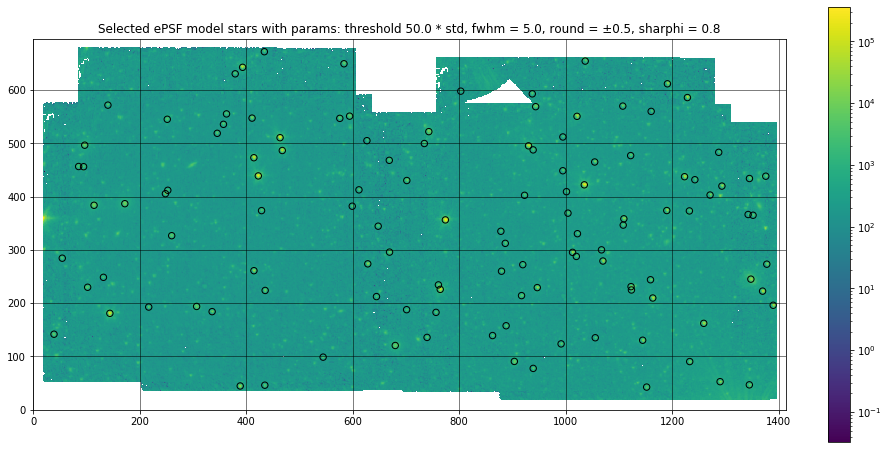

Number of refined ePSF sources = 90



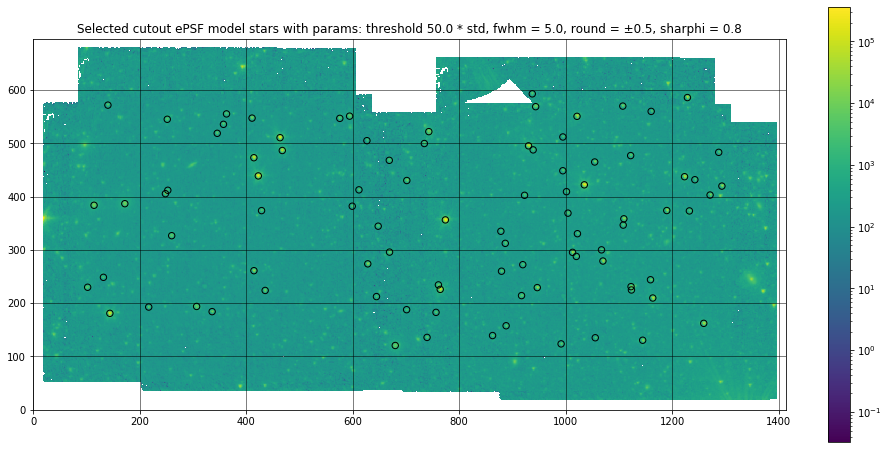

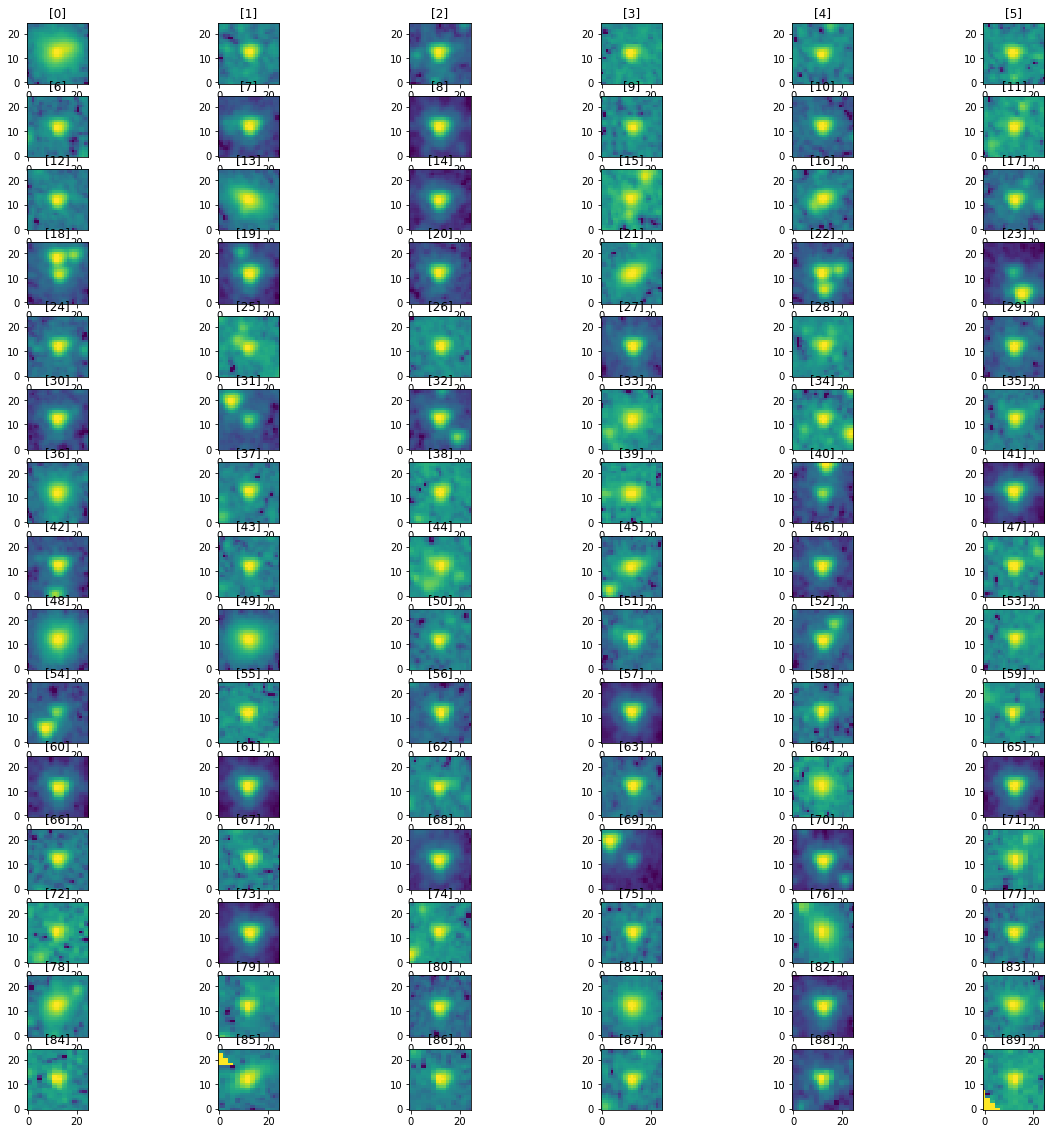

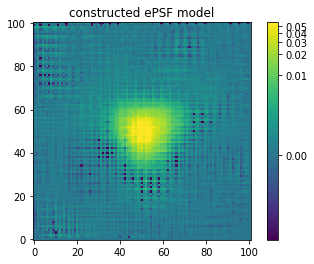

Remove any poor quality model stars from the model by their ID. Use ID -99 to escape
85 89


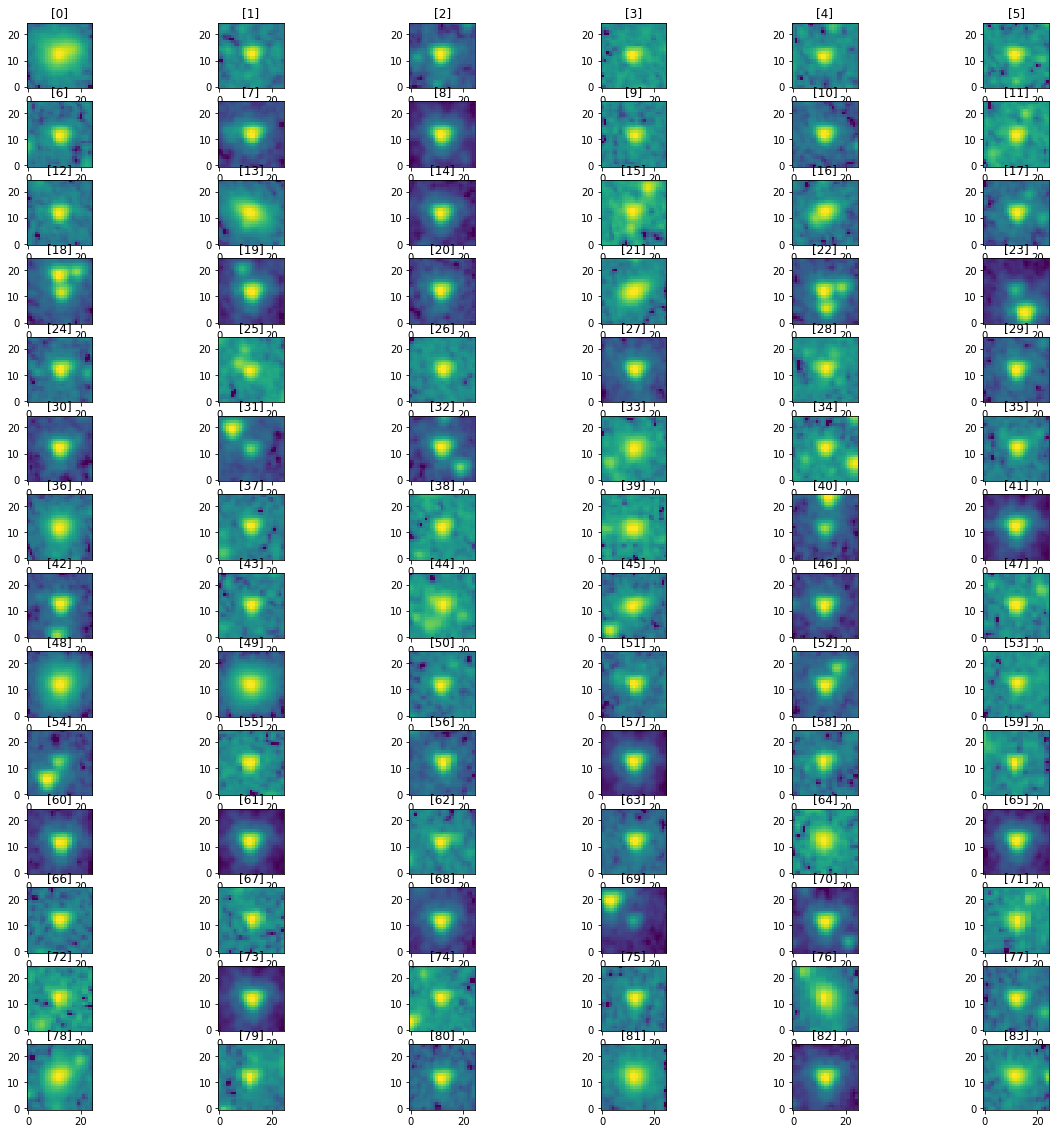

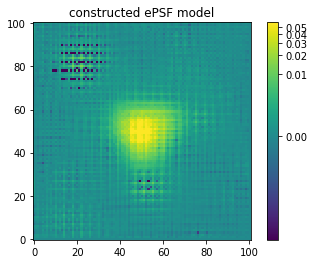

Remove any poor quality model stars from the model by their ID. Use ID -99 to escape
0 13 15 18 21 22 23 25 31 33 34 40 54 74 76 69


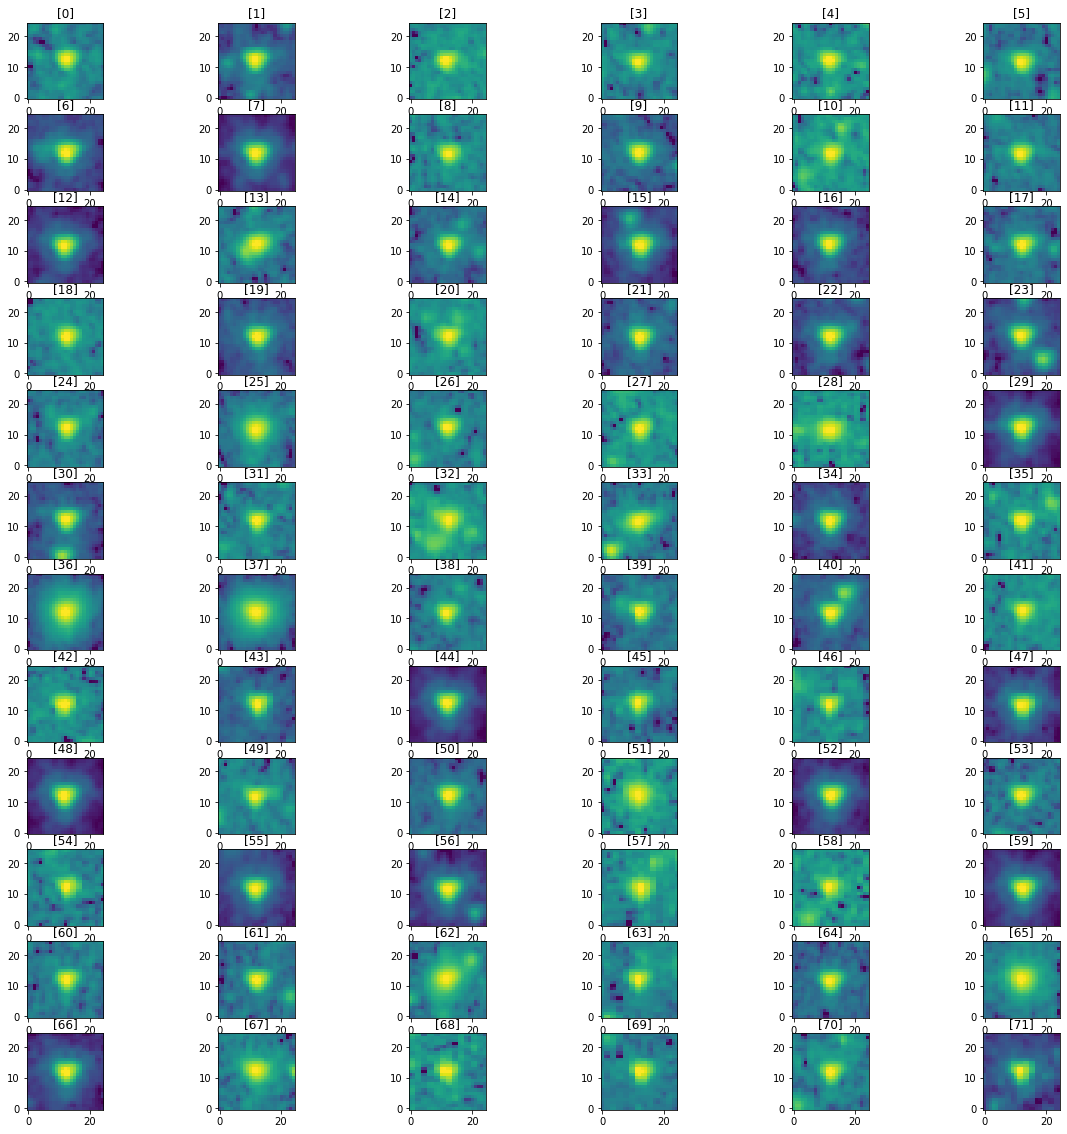

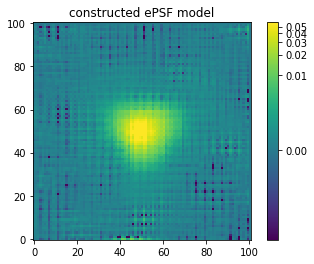

Remove any poor quality model stars from the model by their ID. Use ID -99 to escape
-99
Escape completed



In [5]:
## BASE DATA DIRECTORY ##

base_dir = 'PAL5_data/*/'
general_dir = 'PAL5_data/'
channel = '3p6um'

## CHANNEL ##

if channel == '3p6um':
    aper_corr = 1.1233         # aperture correction for 337 (6,6,14) apertures in channel 1, given in IRAC handbook §4.10
    ap_err = aper_corr * 0.02  # uncertainty to ~2% as per IRAC handbook
    zmag = 18.80               # zeropoint magnitude given in IRAC handbook §4.8
    zmag_err = 0.02            # uncertainty calculated from F0 = 280.9 +/- 4.1 in IRAC handbook
elif channel == '4p5um':
    aper_corr = 1.1336
    ap_err = aper_corr * 0.02
    zmag = 18.32
    zmag_err = 0.02 
    
#____________________________________#
## BUILD ePSF MODEL USING ONE IMAGE ##

epoch_dir = 'PAL5_data/PAL5__e1/'  # specific epoch for ePSF
master_dir = 'PAL5_data/PAL5/'     # mosaic image for ePSF

#epsf_file = epoch_dir+'PAL5__e1_'+channel+'.fits'
epsf_file = master_dir+'PAL5_'+channel+'.fits'

## OPENING FITS FILE AND EXTRACTING DATA ##

with fits.open(epsf_file) as header_list:
    header = header_list[0].header
    fluxconv = header['FLUXCONV']
    exptime = header['EXPTIME']
    time = Time(header['DATE_OBS'])
    counts = exptime / fluxconv
    image_data = fits.getdata(epsf_file, ext = 0)
    data = image_data * counts
    print('FITS file information:\nFILE = {0}\nDATE = {1}\nFLUXCONV = {2}\nEXPTIME = {3}\n\n'.format(epsf_file, time, fluxconv, exptime))

## PARAMETERS : ePSF ##

fwhm = 5.
sigma_val = 6.
model_threshold = 50.
roundlo = -0.5
roundhi = 0.5
sharphi = 0.8
do_plot = True

mean, median, std = sigma_clipped_stats(data, sigma = sigma_val) # sigma-clipping on data

starfind_init = DAOStarFinder(fwhm = fwhm, threshold = model_threshold * std, roundlo = roundlo, roundhi = roundhi, sharphi = sharphi)
epsf_sources = starfind_init(data)
print('Number of ePSF sources found = {0}\n'.format(len(epsf_sources)))

if do_plot == True:
    # PLOT SELECTED STARS TO TEST PARAMETERS #
    positions = np.transpose((epsf_sources['xcentroid'], epsf_sources['ycentroid']))
    apertures = CircularAperture(positions, r = 6.)

    plt.imshow(data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
    apertures.plot(color = 'black', lw = 1.)
    plt.colorbar(fraction = 0.05)
    plt.title('Selected ePSF model stars with params: threshold {0} * std, fwhm = {1}, round = ±{2}, sharphi = {3}'
              .format(model_threshold, fwhm, roundhi, sharphi))
    plt.grid(b = True, which = 'major', lw = .5, color = 'black')
    plt.grid(b = True, which = 'minor', lw = .5, color = 'black')
    plt.gcf().set_size_inches(15, 8)
    plt.show()
    plt.close()

elif do_plot == False:
    pass

## STAR CUTOUTS FOR ePSF ##

cutout_size = 200
hsize = (cutout_size - 1) / 2
x = epsf_sources['xcentroid']
y = epsf_sources['ycentroid']
mask = ((x > hsize) & (x < (data.shape[1] - 1 - hsize)) &
       (y > hsize) & (y < (data.shape[0] - 1 - hsize)))

star_tbl = Table()      # build table of star sources
star_tbl['x'] = x[mask]
star_tbl['y'] = y[mask]
star_tbl['id'] = range(len(star_tbl))
print('Number of refined ePSF sources = {0}\n'.format(len(star_tbl)))

if do_plot == True:
    # PLOT CUTOUT STARS TO BE USED IN EPSF MODEL #
    cutout_pos = np.transpose((star_tbl['x'], star_tbl['y']))
    cutout_apers = CircularAperture(cutout_pos, r = 6.)

    plt.imshow(data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
    cutout_apers.plot(color = 'black', lw = 1.)
    plt.colorbar(fraction = 0.05)
    plt.title('Selected cutout ePSF model stars with params: threshold {0} * std, fwhm = {1}, round = ±{2}, sharphi = {3}'
              .format(model_threshold, fwhm, roundhi, sharphi))
    plt.grid(b = True, which = 'major', lw = .5, color = 'black')
    plt.grid(b = True, which = 'minor', lw = .5, color = 'black')
    plt.gcf().set_size_inches(15, 8)
    plt.show()
    
elif do_plot == False:
    pass

## EXTRACT STARS ##

mean_val, median_val, std_val = sigma_clipped_stats(data, sigma = sigma_val)
epsf_data = data - median_val

while True:
    nddata = NDData(data = epsf_data)
    epsf_stars = extract_stars(nddata, star_tbl, size = 25)

    ## VISUALISE MODEL STARS ##
    ncols = 6
    nrows = int(np.floor(len(epsf_stars) / ncols))
    remaining = len(epsf_stars) - ncols * nrows

    fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20,20), squeeze = True)
    ax = ax.ravel()
    for i in range(nrows * ncols):
        norm = simple_norm(epsf_stars[i], 'log', percent = 99.)
        ax[i].imshow(epsf_stars[i], cmap = 'viridis', norm = norm, origin = 'lower')
        ax[i].set_title([i])
    plt.show()
    for i in range(ncols * nrows, len(epsf_stars)):
        norm = simple_norm(epsf_stars[i], 'log', percent = 99.)
        ax[i - ncols * nrows].imshow(epsf_stars[i], cmap = 'viridis', norm = norm, origin = 'lower')
        ax[i - ncols * nrows].set_title([i])
    plt.show()
    plt.close()
    
    ## BUILD ePSF ##

    epsf_builder = EPSFBuilder(oversampling = 4, maxiters = 10, progress_bar = True)
    epsf, fitter = epsf_builder(epsf_stars)
    
    norm = simple_norm(epsf.data, 'log', percent = 99.)
    plt.imshow(epsf.data, cmap = 'viridis', norm = norm, origin = 'lower')
    plt.title('constructed ePSF model')
    plt.colorbar()
    plt.show()
    
    print('Remove any poor quality model stars from the model by their ID. Use ID -99 to escape')
    remove = [int(k) for k in input().split()]
    
    if remove == [-99]:
        print('Escape completed\n')
        break
    
    star_tbl.add_index('id')
    bad_id = star_tbl.loc_indices[remove]
    star_tbl.remove_rows(bad_id)

#### Building master star list from mosaic image and converting into (α, δ)

FITS file information:
FILE = PAL5_data/PAL5/PAL5_3p6um.fits
FLUXCONV = 0.1257
EXPTIME = 585.054




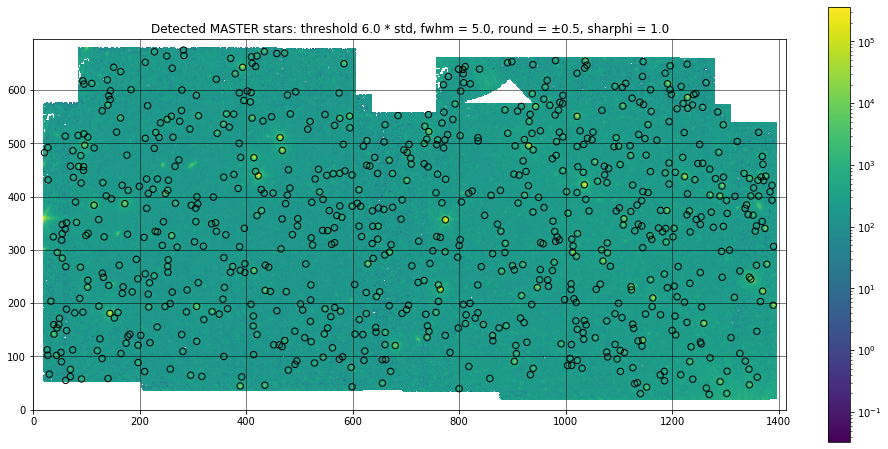

Number of MASTER stars detected = 792



Number of MASTER stars found from PSF = 869

       x_0                y_0         ...      flux_unc      iter_detected
------------------ ------------------ ... ------------------ -------------
1269.5063258483376 28.576868985369124 ...  2867.350660679332             1
1302.5323577023107  30.41383225609205 ...  2769.578187823118             1
1264.2161506278433   40.4727125768036 ...  3231.967094986804             1
1290.0140281406764   52.5272481938853 ...   3566.78671114763             1
1303.1593044119372  72.16214529776158 ... 3080.6912297242557             1
1140.2739672278392 29.994285687889022 ...   723.209651927438             1
1152.0517082774918 42.328688459734956 ...  814.5667586555536             1
1129.5421224473064 48.674351148967304 ...  722.9116974420676             1
1134.6013478827433  50.59324768540729 ...  700.9121023306178             1
 1102.806752375499   71.8541829705888 ...  710.6197292983204             1
               ...                ... ...              

In [6]:
## BUILD MASTER STAR LIST USING MOSAIC ##

master_dir = 'PAL5_data/PAL5/'  # mosaic image for ePSF

master_file = master_dir+'PAL5_'+channel+'.fits'

## OPENING FITS FILE AND EXTRACTING DATA ##

with fits.open(master_file) as header_list:
    master_header = header_list[0].header
    fluxconv = master_header['FLUXCONV']
    exptime = master_header['EXPTIME']
    counts = exptime / fluxconv
    image_data = fits.getdata(master_file, ext = 0)
    master_data = image_data * counts
    print('FITS file information:\nFILE = {0}\nFLUXCONV = {1}\nEXPTIME = {2}\n\n'.format(master_file, fluxconv, exptime))

## PARAMETERS FOR USE ON MASTER IMAGE ##

sigma_master = 6.
fwhm = 5.
r_ap = 6.
r_in = 6.
r_out = 14.
roundlo = -0.5
roundhi = 0.5
sharphi = 1.0
do_plot = False

## SOURCE DETECTION ON MASTER IMAGE ##

mean, median, std = sigma_clipped_stats(master_data, sigma = sigma_val)

master_daofind = DAOStarFinder(fwhm = fwhm, threshold = sigma_master * std, roundlo = roundlo, roundhi = roundhi)
master_sources = master_daofind(master_data)

master_positions = np.transpose((master_sources['xcentroid'], master_sources['ycentroid']))
master_apertures = CircularAperture(master_positions, r = 6.)

plt.imshow(master_data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
master_apertures.plot(color = 'black', lw = 1.)
plt.colorbar(fraction = 0.05)
plt.title('Detected MASTER stars: threshold {0} * std, fwhm = {1}, round = ±{2}, sharphi = {3}'
          .format(sigma_master, fwhm, roundhi, sharphi))
plt.grid(b = True, which = 'major', lw = .5, color = 'black')
plt.grid(b = True, which = 'minor', lw = .5, color = 'black')
plt.gcf().set_size_inches(15, 8)
plt.show()
plt.close()
print('Number of MASTER stars detected = {0}\n'.format(len(master_sources)))
    
## RENAMING STAR LIST TITLES ##

master_sources['xcentroid'].name = 'x_0'
master_sources['ycentroid'].name = 'y_0'
master_sources['id'].name = 'master_id'

## PSF PHOTOMETRY ON MASTER SOURCE ##

daogroup = DAOGroup(crit_separation = sigma_master * fwhm)
bkg_estimator = MMMBackground()
fitter = LevMarLSQFitter()

data_master_psf = np.nan_to_num(data, nan = 1**-7)

## FIXED CENTROIDS WRT TRANSFORMED MASTER POSITIONS ##

master_psf = np.transpose((master_sources['x_0'], master_sources['y_0']))
epsf.x_0.fixed = True
epsf.y_0.fixed = True
pos_master = Table(names = ['x_0', 'y_0'], data = master_psf)
    
## PERFORMING PSF PHOTOMETRY ##

PSF_photometry = IterativelySubtractedPSFPhotometry(finder = master_daofind,
                                                    group_maker = daogroup,
                                                    bkg_estimator = bkg_estimator,
                                                    psf_model = epsf,
                                                    fitter = fitter,
                                                    niters = 3,
                                                    aperture_radius = 6.,
                                                    fitshape = (11, 11))

master_phot = PSF_photometry(image = data_master_psf, init_guesses = pos_master)
residual_image = PSF_photometry.get_residual_image()
    
print('Number of MASTER stars found from PSF = {0}\n'.format(len(master_phot)))
print(master_phot)  

## CONVERT COORDINATES ##

master_list = copy.copy(master_phot)
del master_list['flux_0', 'group_id', 'x_fit', 'y_fit', 'flux_fit', 'flux_unc', 'iter_detected']
master_list['id'].name = 'phot_id'

master_list['master_id'] = int(0)
for i in range(len(master_list)):
    master_list['master_id'][i] = i

del master_list['phot_id']
new_order = ['master_id', 'x_0', 'y_0']
master_list = master_list[new_order]

w = wcs.WCS(master_header)
coord = np.transpose((master_list['x_0'], master_list['y_0']))
world = w.wcs_pix2world(coord, 0)

m_ra, m_dec = world[:, 0], world[:, 1]
m_c = SkyCoord(m_ra, m_dec, frame = 'icrs', unit = 'deg')

master_list['ra'] = m_ra
master_list['dec'] = m_dec

## EXPORT PHOTOMETRY FILE AND PRINT TO SCREEN ##

master_list['master_id', 'x_0', 'y_0', 'ra', 'dec'].write(
    r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\PAL5_PSFmaster_03_channel{0}.txt'.format(channel), format = 'csv', overwrite = True)
    
print(master_list['master_id', 'x_0', 'y_0', 'ra', 'dec'])
print('\n\n')

EPOCH NUMBER = 1

FITS file information:
FILE = PAL5_data\PAL5__e1\PAL5__e1_3p6um.fits
DATE = 2013-05-10T21:50:03.531
FLUXCONV = 0.1257
EXPTIME = 71.3724




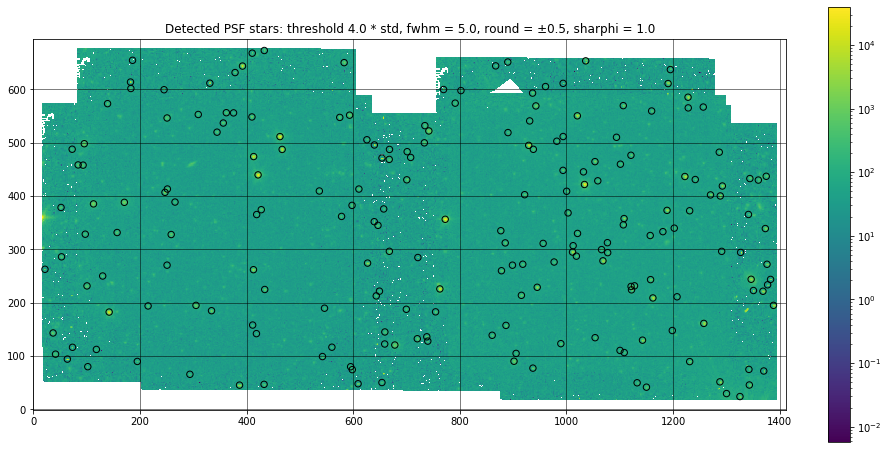

Number of stars detected = 208



Number of PSF stars found and analysed = 916

 id       x_fit        ...    apparent_mag      apparent_mag_unc  
--- ------------------ ... ------------------ --------------------
  1 1267.5782204800744 ... 16.918502645614176  0.03856892260645879
  3 1262.3134422773655 ... 17.515650348594797  0.06287973244514593
  2 1300.6077332762948 ... 16.476762534711778 0.053889084106175794
793 1304.6960478087926 ... 17.249405961838228  0.10279138273630561
  4  1288.136649696235 ... 13.921928299941198  0.03590039090129436
  5 1301.3235604708043 ... 18.120182747963494  0.06676598593853975
  6  1138.350563302125 ...  17.28447360280196  0.05910365453133775
  7 1150.1544127823054 ... 15.287977910089394 0.026158187917480296
  8  1127.658631092976 ...  17.69890459113787  0.06931535119273262
  9 1132.7218762498355 ... 16.614830603390192  0.03420786757371502
...                ... ...                ...                  ...
 37 1194.9174746047229 ... 15.842157218313353  0.04419180417344042
 38  390.6172432

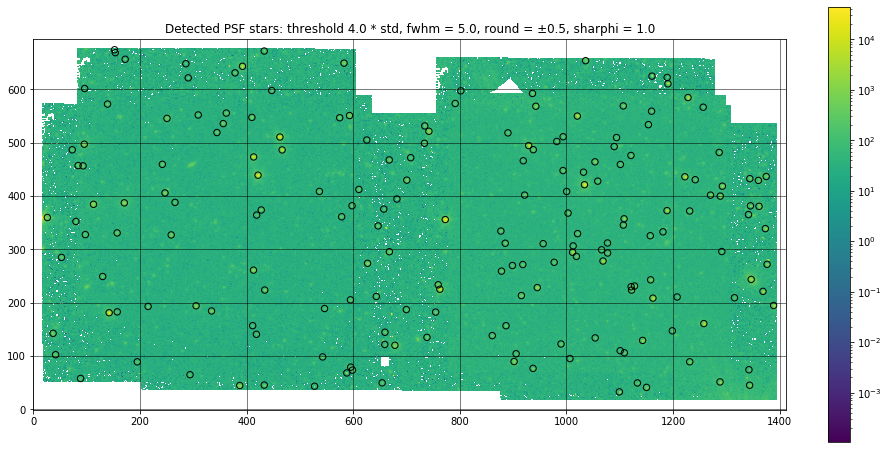

Number of stars detected = 192



Number of PSF stars found and analysed = 894

 id       x_fit        ...    apparent_mag      apparent_mag_unc  
--- ------------------ ... ------------------ --------------------
  1 1267.7948608295515 ... 17.064378397663084  0.04516462742063839
  3 1262.5238378231513 ... 17.546670237400104 0.061774045221869106
  2 1300.8259213288482 ... 16.480792064327765 0.054819923873833304
793 1304.9189891380859 ... 17.116558960179017  0.09749497138776109
  4 1288.3430299147233 ... 14.178955757190808 0.031125909402533805
  5 1301.5212570663482 ... 18.005596461186034  0.07290519445142801
  6  1138.556913943846 ...  17.45249345395174 0.059878478900213444
  7 1150.3555697567758 ... 15.397646877591091  0.02630590428577388
  8  1127.854995533795 ...  17.52819365866732  0.08415924886559273
  9 1132.9176722201514 ... 16.179828534328337  0.03438931731125299
...                ... ...                ...                  ...
 15  447.2427564092031 ...  15.50009987255303  0.04578514522868888
 16  96.26239118

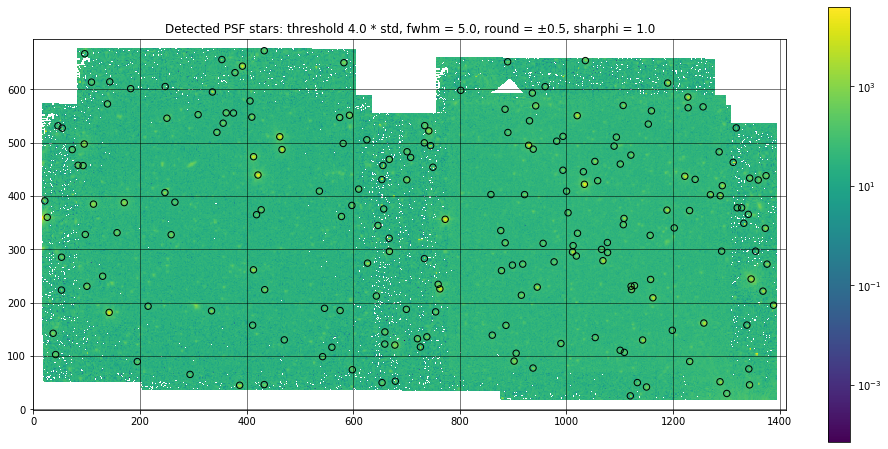

Number of stars detected = 207



KeyboardInterrupt: 

In [7]:
## PSF PHOTOMETRY ON ALL EPOCHS ##

## PARAMETERS ##

sigma_psf = 4.
fwhm = 5.
r_ap = 6.
r_in = 6.
r_out = 14.
roundlo = -0.5
roundhi = 0.5
sharphi = 1.0
do_plot = False

## EPOCH LOOP COUNTER ##

epoch = 0

## COPY MASTER TABLE AS MAIN TABLE ##

#main_table = copy.copy(master_sources)
main_table = copy.copy(master_list)

## STORING EPOCH TIMES AS MODIFIED JULIAN DATE VALUES ## #could refine/update later?

epoch_time = []

## PSF PHOTOMETRY LOOP ##
for file in glob.glob(base_dir+'PAL5__e[0-9]_'+channel+'.fits', recursive = True) + glob.glob(base_dir+'PAL5__e[0-9][0-9]_'+channel+'.fits', recursive = True):
    epoch += 1
    print('EPOCH NUMBER = {0}\n'.format(epoch))
    ## OPENING FITS FILE AND EXTRACTING DATA ##
    with fits.open(file) as header_list:
        header = header_list[0].header
        fluxconv = header['FLUXCONV']
        exptime = header['EXPTIME']
        time = Time(header['DATE_OBS'])
        counts = exptime / fluxconv
        
        image_data = fits.getdata(file, ext = 0)
        data = image_data * counts
        
        print('FITS file information:\nFILE = {0}\nDATE = {1}\nFLUXCONV = {2}\nEXPTIME = {3}\n\n'.format(file, time, fluxconv, exptime))

    ## EXTRACT TIME FROM EPOCH ##
    
    epoch_time.append(Time(header['DATE_OBS'], format = 'isot', scale = 'utc').mjd)
    
    ## EXTRACTING LOC-DEPENDENT CORRECTIONS ##
    corr_file = general_dir+'PAL5__e'+str(epoch)+'/PAL5__e'+str(epoch)+'_correction_'+channel+'.fits'
    with fits.open(corr_file) as hdu_list:
        corr_data = hdu_list[0].data
    
    ## SOURCE DETECTION ON IMAGE ## 
    psf_daofind = DAOStarFinder(fwhm = fwhm, threshold = sigma_psf * std, roundlo = roundlo, roundhi = roundhi)
    psf_sources = psf_daofind(data)

    psf_positions = np.transpose((psf_sources['xcentroid'], psf_sources['ycentroid']))
    psf_apertures = CircularAperture(psf_positions, r = 6.)

    plt.imshow(data, cmap = 'viridis', origin = 'lower', norm = LogNorm(), interpolation = 'nearest')
    psf_apertures.plot(color = 'black', lw = 1.)
    plt.colorbar(fraction = 0.05)
    plt.title('Detected PSF stars: threshold {0} * std, fwhm = {1}, round = ±{2}, sharphi = {3}'
              .format(sigma_psf, fwhm, roundhi, sharphi))
    plt.grid(b = True, which = 'major', lw = .5, color = 'black')
    plt.grid(b = True, which = 'minor', lw = .5, color = 'black')
    plt.gcf().set_size_inches(15, 8)
    plt.show()
    plt.close()
    print('Number of stars detected = {0}\n'.format(len(psf_sources)))
    
    ## GROUP ##

    psf_sources['xcentroid'].name = 'x_0'
    psf_sources['ycentroid'].name = 'y_0'
    
    ## ALIGN THE MASTER POSITIONS TO THE EPOCH FRAME ##
    
    #master_pos = np.transpose((master_sources['x_0'], master_sources['y_0']))
    #tf, (tf_source, tf_target) = aa.find_transform(master_data, data)
    #master_tf = aa.matrix_transform(master_pos, tf.params)
    master_pos = np.transpose((master_list['x_0'], master_list['y_0']))
    tf, (tf_source, tf_target) = aa.find_transform(master_data, data)
    master_tf = aa.matrix_transform(master_pos, tf.params)

    daogroup = DAOGroup(crit_separation = sigma_psf * fwhm)
    bkg_estimator = MMMBackground()
    fitter = LevMarLSQFitter()

    data_psf = np.nan_to_num(data, nan = 1**-7)

    ## FIXED CENTROIDS WRT TRANSFORMED MASTER POSITIONS ##

    epsf.x_0.fixed = True
    epsf.y_0.fixed = True
    pos = Table(names = ['x_0', 'y_0'], data = master_tf)
    
    ## PERFORMING PSF PHOTOMETRY ##

    PSF_photometry = IterativelySubtractedPSFPhotometry(finder = psf_daofind,
                                                        group_maker = daogroup,
                                                        bkg_estimator = bkg_estimator,
                                                        psf_model = epsf,
                                                        fitter = fitter,
                                                        niters = 3,
                                                        aperture_radius = 6.,
                                                        fitshape = (11, 11))

    result_phot = PSF_photometry(image = data_psf, init_guesses = pos)
    residual_image = PSF_photometry.get_residual_image()
    
    #hdu = fits.PrimaryHDU(residual_image)
    #hdul = fits.HDUList([hdu])
    #hdul.writeto('residual_image_08_fixed_centroids.fits')
    print('Number of PSF stars found and analysed = {0}\n'.format(len(result_phot)))
    
    if do_plot == True:
        ## VISUALISE PSF IMAGE AND RESIDUALS ##
        plt.subplot(1, 2, 1)
        plt.imshow(data_psf, cmap = 'viridis', norm = LogNorm(), interpolation = 'nearest', origin = 'lower', vmin = 0.000001, vmax = 10**6)
        plt.title('input data')
        plt.colorbar(orientation = 'horizontal')

        plt.subplot(1, 2, 2)
        plt.imshow(residual_image, cmap = 'viridis', norm = LogNorm(), interpolation = 'nearest', origin = 'lower', vmin = 0.000001, vmax = 10**6)
        plt.title('residual image')
        plt.colorbar(orientation = 'horizontal')
        plt.gcf().set_size_inches(20, 14)
        plt.show()
        plt.close()
    elif do_plot == False:
        pass
    
    phot = result_phot   # REDEFINE PHOTOMETRY TABLE FOR EASE
    #print(phot)
    
    ## PHOTOMETRY: UNCERTAINTIES ##
    
    PSF_err = phot['flux_unc']
    PSF_flux = phot['flux_fit'] 
    
    ## APPARENT MAGNITUDES ##
    
    phot['apparent_mag'] = float('NaN')
    for i in range(0, len(phot)):
        # APPLY ARRAY-LOC DEP CORRECTION
        loc_corr = corr_data[int(phot['y_fit'][i])][int(phot['x_fit'][i])]
        if phot['flux_fit'][i] >= 0:
            phot['apparent_mag'][i] = zmag - 2.5 * math.log10(phot['flux_fit'][i] * aper_corr * loc_corr / counts)
    
    ## APPARENT MAGNITUDE: UNCERTAINTIES ##
    
    phot['apparent_mag_unc'] = float('Nan')
    for i in range(0, len(phot)):
        if phot['flux_fit'][i] >= 0:
            phot['apparent_mag_unc'][i] = pow(zmag_err**2 + (2.5*(pow((PSF_err[i] / PSF_flux[i])**2 + (ap_err / aper_corr)**2, 0.5) / (np.log(10)))**2), 0.5)
    
    ## CONVERT COORDINATES ##
    
    w = wcs.WCS(header)
    coord = np.transpose((phot['x_fit'], phot['y_fit']))
    world = w.wcs_pix2world(coord, 0)

    e_ra, e_dec = world[:, 0], world[:, 1]
    e_c = SkyCoord(e_ra, e_dec, frame = 'icrs', unit = 'deg')

    phot['ra'] = e_ra
    phot['dec'] = e_dec
    
    ## APPEND APPARENT MAGNITUDE AND UNCERTAINTY COLUMNS FOR EACH EPOCH ##
    
    epoch_table = copy.copy(phot)
    # DELETE CERTAIN COLUMNS TO AVOID CRAMMING NEW EPOCH TABLE
    del epoch_table['x_0', 'y_0', 'flux_0', 'flux_unc', 'iter_detected']
    epoch_mag = 'mag_epoch'+str(epoch)
    epoch_unc = 'unc_epoch'+str(epoch)
    epoch_ra = 'ra_epoch'+str(epoch)
    epoch_dec = 'dec_epoch'+str(epoch)
    # RENAME COLUMNS FOR EASE
    epoch_table.rename_column('ra', epoch_ra)
    epoch_table.rename_column('dec', epoch_dec)
    epoch_table.rename_column('apparent_mag', epoch_mag)
    epoch_table.rename_column('apparent_mag_unc', epoch_unc)

    ## EXPORT PHOTOMETRY FILE AND PRINT TO SCREEN ##
    phot['id', 'ra', 'dec', 'apparent_mag', 'apparent_mag_unc'].write(
        r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\PAL5_PSFphot_03_epoch{0}_channel{1}.txt'.format(epoch, channel), format = 'csv', overwrite = True)
    
    print(phot['id', 'x_fit', 'y_fit', 'ra', 'dec', 'apparent_mag', 'apparent_mag_unc'])
    print('\n\n')

    ## PHOTOMETRY COMPLETE -- APPARENT MAGNITUDES AND UNCERTAINTIES OBTAINED FOR ALL EPOCHS ##

    ## MATCH STARS FROM EPOCHS TO MASTER STAR LIST ##

    temp_table = copy.copy(main_table)
    
    w = wcs.WCS(header)
    coord = np.transpose((epoch_table['x_fit'], epoch_table['y_fit']))
    world = w.wcs_pix2world(coord, 0)

    ra, dec = world[:, 0], world[:, 1]
    c = SkyCoord(ra, dec, frame = 'icrs', unit = 'deg')

    epoch_table['ra'] = ra
    epoch_table['dec'] = dec
    
    idx, d2d, d3d = c.match_to_catalog_sky(m_c)
    
    # ENSURE MATCHES ARE SIGNIFICANT
    radius = 0.0001
    selection = (d2d > radius*u.deg)
    match_index = idx
    match_index[selection] = -99.
    matches = (match_index >= 0)
    
    temp_table = temp_table[match_index][matches]
    epoch_table = epoch_table[matches]
    
    # ASSIGN EPOCH TABLE ID EQUIVALENT TO MASTER ID
    epoch_table['master_id'] = temp_table['master_id']
    
    main_table = join(main_table, epoch_table['master_id', epoch_ra, epoch_dec, epoch_mag, epoch_unc], keys = 'master_id', join_type = 'left')
    
    #if epoch == 1:
    #    del main_table['sharpness', 'roundness1', 'roundness2', 'npix', 'sky', 'peak', 'flux', 'mag']
    #else:
    #    pass
    
    print(main_table)
    
    main_table.write(r'C:\Users\lukeb\Documents\MPhys_Project_RRLs\Luke_RRLs_project\output_files\PAL5_main_02_epoch{0}_channel{1}.txt'.format(epoch, channel), format = 'csv', overwrite = True)

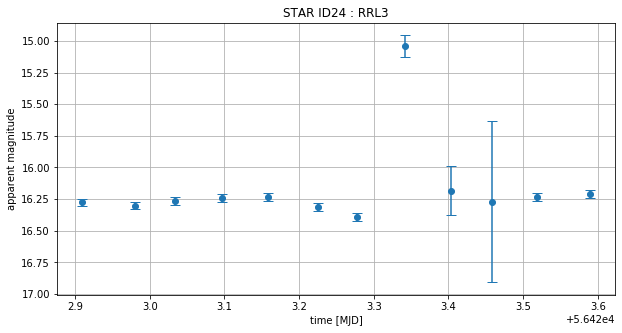

In [34]:
## LIGHT CURVES: PLOTTING ##

mag = []
mag_err = []

star_id = 24
RRL = 3
#572

for i in range(1, 13):
    epoch = i
    mag.append(main_table[star_id]['mag_epoch'+str(i)])

for j in range(1, 13):
    epoch = j
    mag_err.append(main_table[star_id]['unc_epoch'+str(j)])

plt.plot(epoch_time, mag, color = 'k', linestyle = 'None', markersize = 5)
plt.errorbar(x = epoch_time, y = mag, xerr = None, yerr = mag_err, fmt = 'o', capsize = 5)
plt.title('STAR ID{0} : RRL{1}'.format(star_id, RRL))
plt.xlabel('time [MJD]')
plt.ylabel('apparent magnitude')
plt.grid()
plt.gca().invert_yaxis()
plt.gcf().set_size_inches(10, 5)
plt.savefig('lc_figs\lc_star_{0}_RRL_{1}_{2}_attempt_f'.format(star_id, RRL, channel), dpi = 500)
plt.show()
plt.close()